K-Means performance evaluation

CIFAR-10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from load_data import load_cifar10_data, load_cifar100_data
from kmeans_benchmark import elbow_method, bench_k_means


np.random.seed(0)


def flatten_data(x):
    samples = x.shape[0]
    flattened_shape = 1
    for dim in x.shape[1:]:
        flattened_shape *= dim
    return x.reshape(samples, flattened_shape)

def pca_encode(pca_model, X):
    return pca_model.transform(X)

def pca_decode(pca_model, X):
    return pca_model.inverse_transform(X)

def clusters_to_index(cluster_labels):
    dict = {}
    for i in range(len(cluster_labels)):
        if cluster_labels[i] in dict:
            dict[cluster_labels[i]].append(i)
        else:
            dict[cluster_labels[i]] = [i]
    return dict

# reconstruct data from N*3072 to N*32*32*3
def construct_image_from_flattern(x, colored = True):
    samples = x.shape[0]
    if colored:
      return x.reshape(samples, 32, 32, 3).astype("uint8")
    else:
      return x.reshape(samples, 32, 32).astype("uint8")

#visualize image data, displayed on row*col grid, x's 1st-dim >= (row*col)
def visualize_data(x, n, ncol, plt_size):
    nrow = n // ncol + 1
    #fig, axes1 = plt.subplots(nrows=nrow, ncols=ncol)
    plt.figure(figsize=(plt_size, plt_size))
    for i in range(n):
        #if i == n: break
        plt.subplot(nrow, ncol, i+1)
        plt.axis("off")
        plt.imshow(x[i])
        #axes1[k].set_axis_off()
        #axes1[k].imshow(x[k])
    plt.tight_layout()
    plt.show()
    return
    
# visualizing kmeans cluster centers
def visualize_kmeans_centre(kmeans_model, pca_model, n, ncol, colored = True):
    cluster_centers = kmeans_model.cluster_centers_
    cluster_centers_decoded = pca_decode(pca_model, cluster_centers)
    cluster_centers_decoded_image = construct_image_from_flattern(cluster_centers_decoded, colored)
    visualize_data(cluster_centers_decoded_image, n, ncol, 15)


def select_data(data, labels, class_of_interest, class_size, dataset='cifar10', train=True):

    n = len(class_of_interest)
    if dataset == 'cifar10':
        class_size = max(0, min(class_size, (5000 if train else 1000)))
        if n > 10: raise Exception("Out of range")
    elif dataset == 'cifar100':
        class_size = max(0, min(class_size, (500 if train else 100)))
        if n > 100: raise Exception("Out of range")

    arr_size = int(n*class_size)
    print(arr_size)
    data_new = np.empty((arr_size, *data[0].shape))
    labels_new = np.empty((arr_size, ))

    for i in range(n):
        indices = np.argwhere(labels == class_of_interest[i]).squeeze()
        indices = indices[:class_size]
        #indices = np.random.permutation(indices)[:class_size]

        data_new[i*class_size : (i+1)*class_size] = data[indices]
        labels_new[i*class_size : (i+1)*class_size] = labels[indices]

    np.random.seed(0)
    indices_new = np.random.permutation(arr_size)
    data_new = (data_new[indices_new] / 255).astype(np.float)
    labels_new = labels_new[indices_new].astype(np.uint8)

    return data_new, labels_new


2000
(2000, 32, 32, 3)
(2000,)


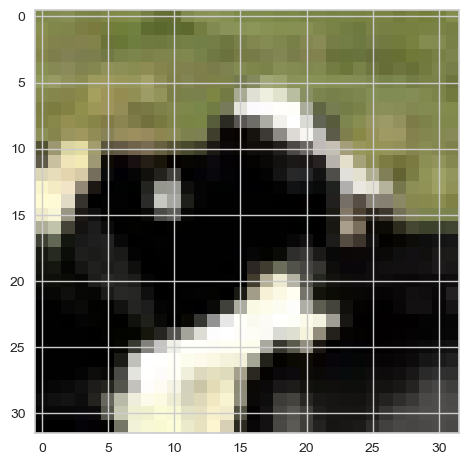

19
(2000, 3072)


In [19]:
# cifar_10_dir = 'cifar-10-batches-py'
# load data
cifar10_train_data, cifar10_train_labels, cifar10_test_data, cifar10_test_labels = load_cifar10_data()
cifar100_train_data, cifar100_train_labels, cifar100_test_data, cifar100_test_labels = load_cifar100_data()

#X, y = select_data(cifar10_test_data, cifar10_test_labels, class_of_interest=[i for i in range(4)], class_size=500, dataset='cifar10', train=False)
#X, y = select_data(cifar10_test_data, cifar10_test_labels, class_of_interest=[1, 7, 8, 9], class_size=500, dataset='cifar10', train=False)
X, y = select_data(cifar100_train_data, cifar100_train_labels, class_of_interest=[i for i in range(20)], class_size=100, dataset='cifar100')
print(X.shape)
print(y.shape)
plt.imshow(X[100])
plt.show()
print(y[100])
# 
# flatten data
# train_vec = flatten_data(train_data)
# test_vec = flatten_data(test_data)
# print(train_vec.shape)
X_flat = flatten_data(X)
print(X_flat.shape)

In [20]:
from Siamese import CNN
import os
# for emb_size in [1, 5]

def load_SNN(vec_size):
    net = CNN(embSize=vec_size)
    path = os.path.join('Siamese', 'models', f'siameseArchEmb{str(vec_size)}Run3.pth')
    net = torch.load(path)
    net.eval()
    return net

def get_SNN_vec(net, X):
    # Siamese Feature Vector
    feature_vec = []
    for i in range(X.shape[0]):
        img = torch.from_numpy(X[i].transpose(2, 0, 1)).type(torch.FloatTensor)
        out = torch.squeeze(net(img)).detach().numpy()
        feature_vec.append(out)

    feature_vec = np.array(feature_vec)
    #print(feature_vec.shape)
    return feature_vec

In [121]:
# CIFAR10DataVal = np.load('CIFARValData.npz')['arr_0']

# data = []
# labels = []
# for classno, classimg in enumerate(CIFAR10DataVal):
#     for i in range(len(classimg)):
#         data.append(classimg[i]/255)
#         labels.append(classno)

(2000, 5)


Feature vector size:  5


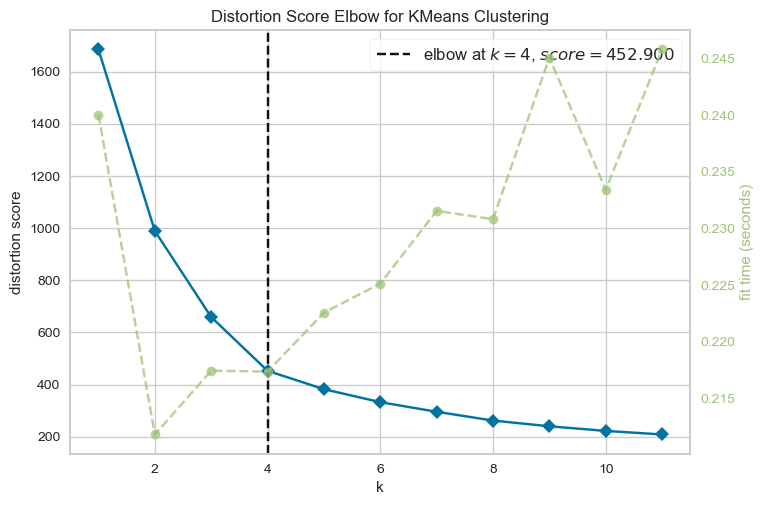

Feature vector size:  10


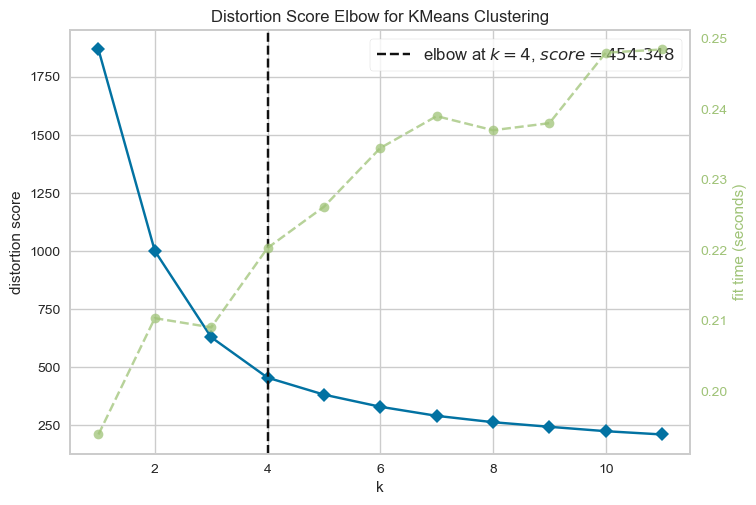

Feature vector size:  20


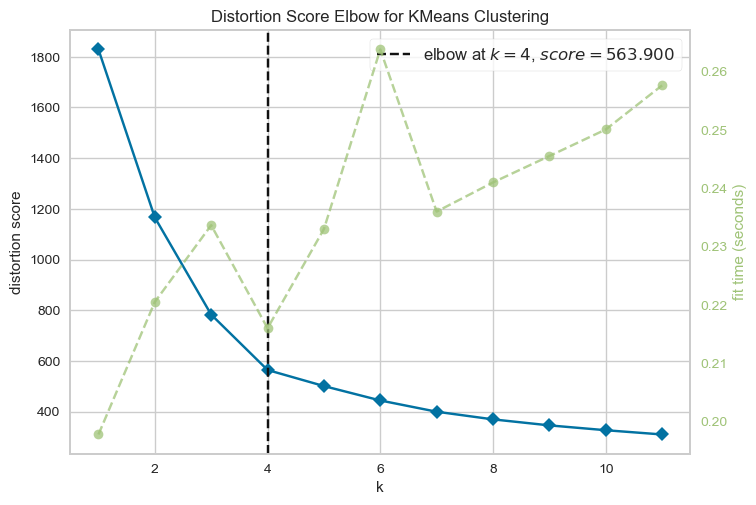

Feature vector size:  50


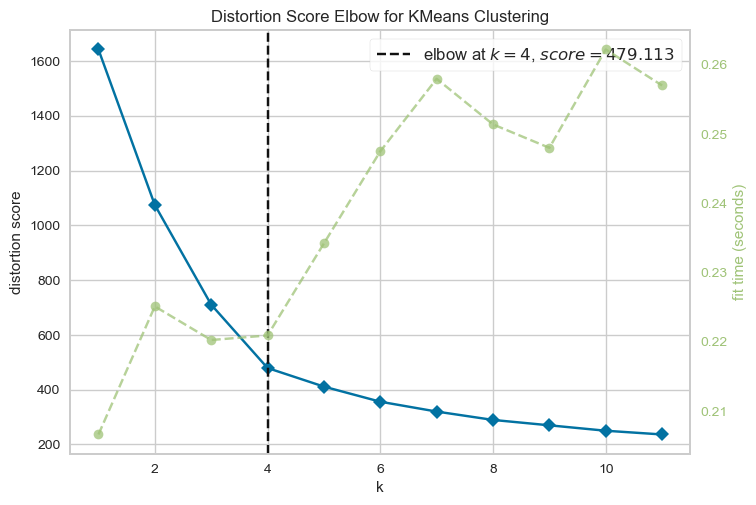

In [4]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# #PCA
# feature_vector_size = 50
# pca_model = PCA(n_components=feature_vector_size).fit(test_vec)
# encoded = pca_model.transform(test_vec)
# print(encoded.shape)

# test for optimal k using elbow plot
# elbow method 
# elbow_method(X, range(1,10), method='inertia')
for vec_size in [5, 10, 20, 50]:
    SNN = load_SNN(vec_size)
    X_vec = get_SNN_vec(SNN, X)
    model = KMeans()
    visualizer1 = KElbowVisualizer(model, k=(1,12))
    #visualizer2 = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz')
    print("Feature vector size: ", vec_size)
    visualizer1.fit(X_vec)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure
   

In [21]:
# test performance with different number of cluster / PCA feature vector size

print("Evaluating PCA ...")
print(100 * "_")
#print("init\t\ttime\tinertia\t\thomo\tcompl\tv-meas\tARI\tNMI\tsilhouette\tcalinski\tdavies")
print("Model\t\tTime\tNMI\tARI\tV-meas\tSilhouette\tCalinski")

# for n_clusters in [3, 4, 5]:
#     for feature_vector_size in [10, 50, 100, 200]:
#         kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#         pca_model = PCA(n_components=feature_vector_size).fit(X_flat)
#         encoded = pca_model.transform(X_flat)
#         #print(encoded.shape)
#         kmeans_pca = bench_k_means(kmeans, name="PCA-" + "n" + str(n_clusters) + "v" + str(feature_vector_size), data=encoded, labels=y)

for n_clusters in [15, 20, 25]:
    for feature_vector_size in [10, 50, 100, 200]:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        pca_model = PCA(n_components=feature_vector_size).fit(X_flat)
        encoded = pca_model.transform(X_flat)
        #print(encoded.shape)
        kmeans_pca = bench_k_means(kmeans, name="PCA-" + "n" + str(n_clusters) + "v" + str(feature_vector_size), data=encoded, labels=y)

print(100 * "_")

Evaluating PCA ...
____________________________________________________________________________________________________
Model		Time	NMI	ARI	V-meas	Silhouette	Calinski
PCA-n15v10	0.250s	0.130	0.039	0.130	0.106		232.167
PCA-n15v50	0.270s	0.130	0.040	0.130	0.067		134.313
PCA-n15v100	0.275s	0.131	0.040	0.131	0.058		118.853
PCA-n15v200	0.292s	0.127	0.039	0.127	0.057		108.985
PCA-n20v10	0.251s	0.134	0.037	0.134	0.101		191.715
PCA-n20v50	0.258s	0.143	0.039	0.143	0.055		107.370
PCA-n20v100	0.280s	0.143	0.039	0.143	0.050		94.266
PCA-n20v200	0.315s	0.144	0.040	0.144	0.050		86.602
PCA-n25v10	0.254s	0.155	0.041	0.155	0.096		164.488
PCA-n25v50	0.272s	0.156	0.043	0.156	0.052		90.789
PCA-n25v100	0.286s	0.151	0.038	0.151	0.046		79.340
PCA-n25v200	0.341s	0.148	0.038	0.148	0.048		73.255
____________________________________________________________________________________________________


In [22]:
print("\nEvaluating Siamese ...")
print(100 * "_")
#print("init\t\ttime\tinertia\t\thomo\tcompl\tv-meas\tARI\tNMI\tsilhouette\tcalinski\tdavies")
print("Model\t\tTime\tNMI\tARI\tV-meas\tSilhouette\tCalinski")

# cifar10
# for n_clusters in [3, 4, 5]:
#     for feature_vector_size in [5, 10, 20, 50]:
#         SNN = load_SNN(feature_vector_size)
#         X_vec = get_SNN_vec(SNN, X)
#         kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#         kmeans_siamese = bench_k_means(kmeans, name="SNN-" + "n" + str(n_clusters) + "v" + str(feature_vector_size), data=X_vec, labels=y)

# cifar100
for n_clusters in [15, 20, 25]:
    for feature_vector_size in [5, 10, 20, 50]:
        SNN = load_SNN(feature_vector_size)
        X_vec = get_SNN_vec(SNN, X)
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans_siamese = bench_k_means(kmeans, name="SNN-" + "n" + str(n_clusters) + "v" + str(feature_vector_size), data=X_vec, labels=y)

print(100 * "_")


Evaluating Siamese ...
____________________________________________________________________________________________________
Model		Time	NMI	ARI	V-meas	Silhouette	Calinski
SNN-n15v5	0.259s	0.089	0.022	0.089	0.262		975.861
SNN-n15v10	0.258s	0.087	0.022	0.087	0.267		1092.153
SNN-n15v20	0.263s	0.095	0.025	0.095	0.213		589.155
SNN-n15v50	0.267s	0.088	0.023	0.088	0.249		843.384
SNN-n20v5	0.262s	0.097	0.021	0.097	0.245		885.182
SNN-n20v10	0.259s	0.097	0.022	0.097	0.247		974.106
SNN-n20v20	0.272s	0.102	0.024	0.102	0.209		514.034
SNN-n20v50	0.293s	0.096	0.021	0.096	0.233		759.005
SNN-n25v5	0.260s	0.105	0.019	0.105	0.246		828.029
SNN-n25v10	0.266s	0.103	0.020	0.103	0.237		888.772
SNN-n25v20	0.298s	0.112	0.024	0.112	0.199		466.493
SNN-n25v50	0.306s	0.102	0.019	0.102	0.231		696.919
____________________________________________________________________________________________________


0


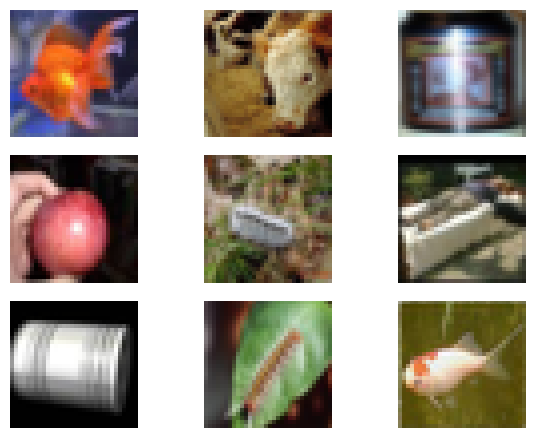

1


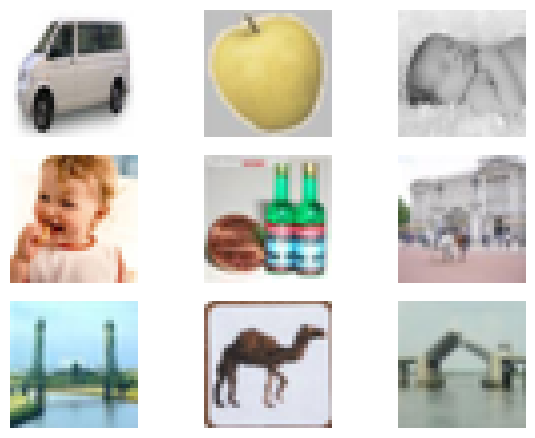

2


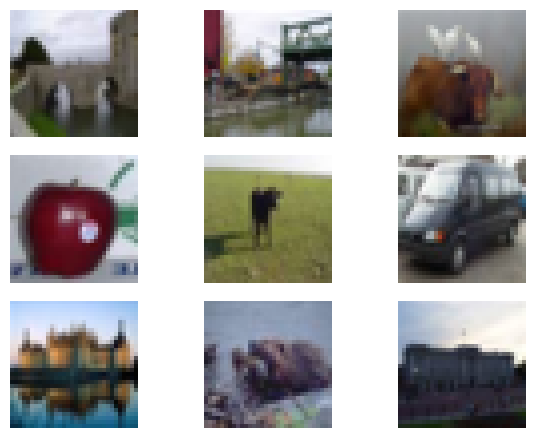

3


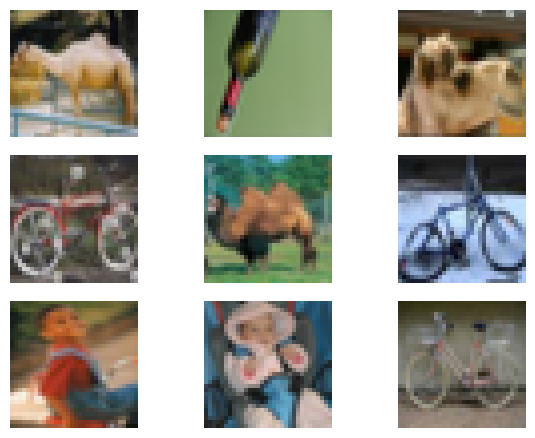

4


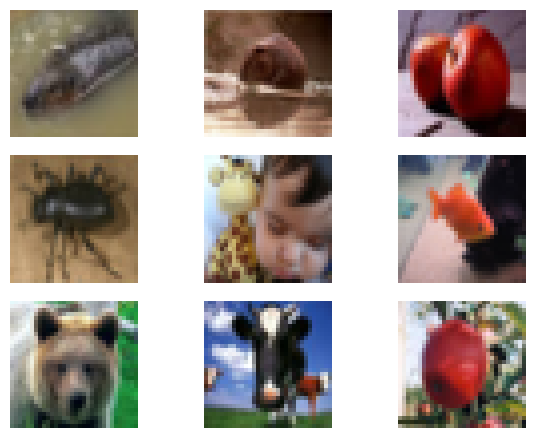

5


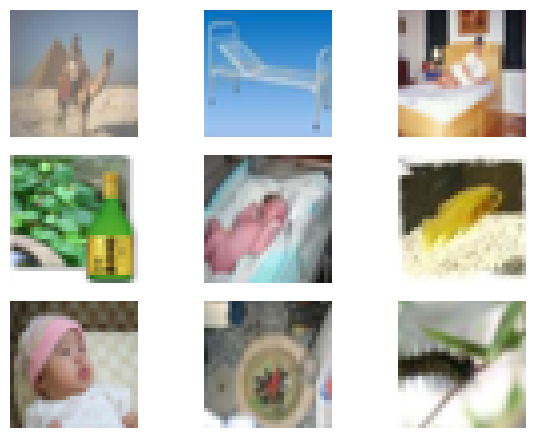

6


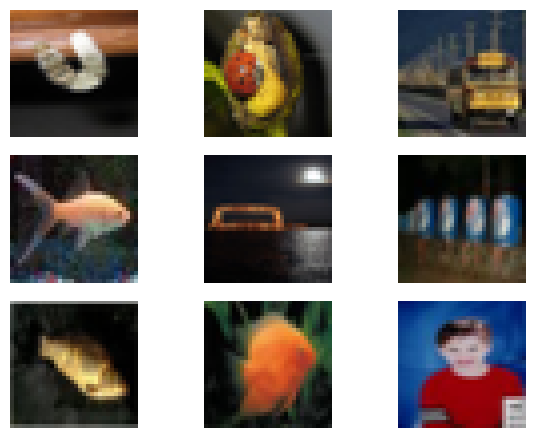

7


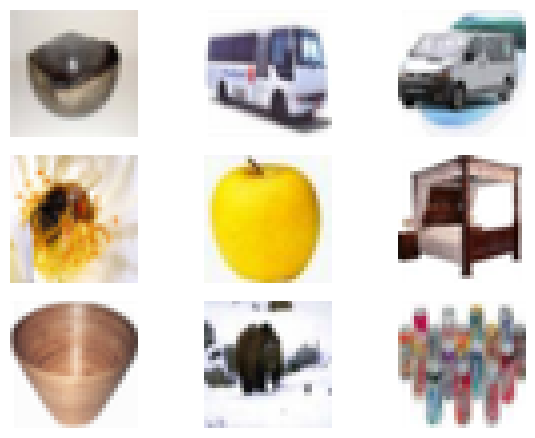

8


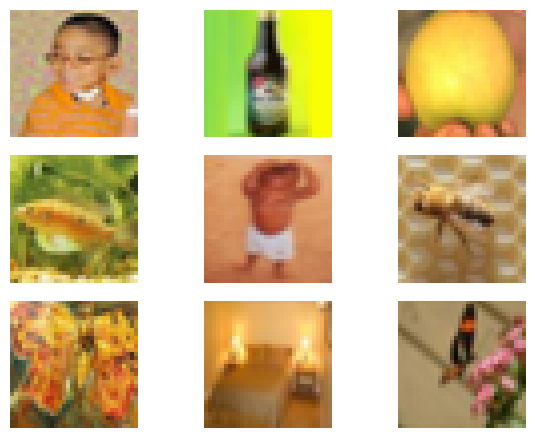

9


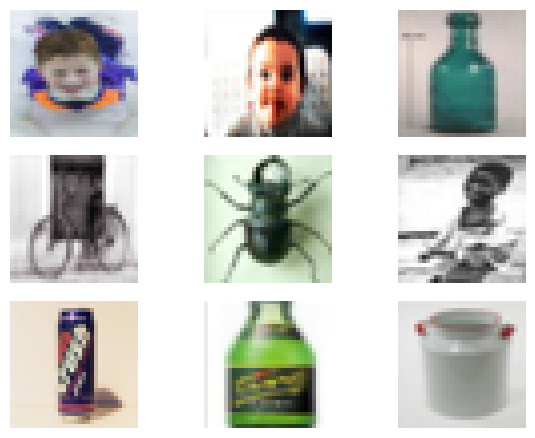

10


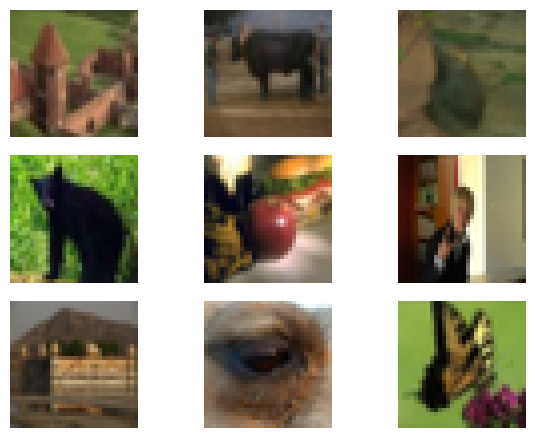

11


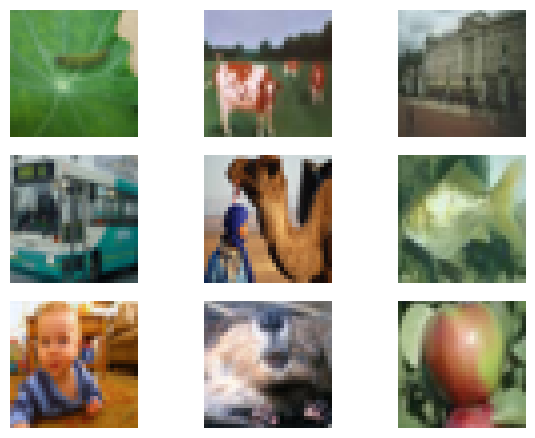

12


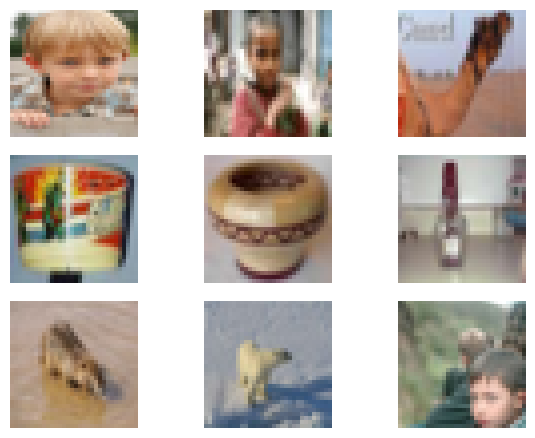

13


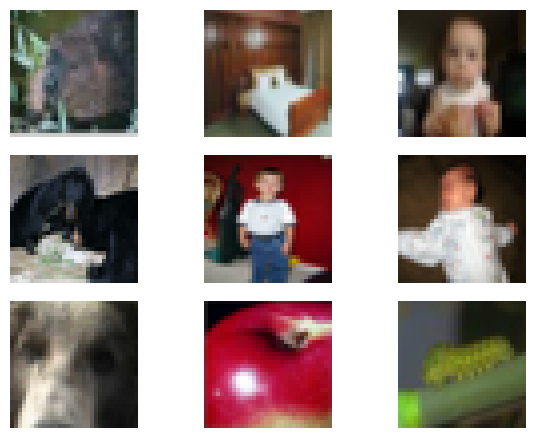

14


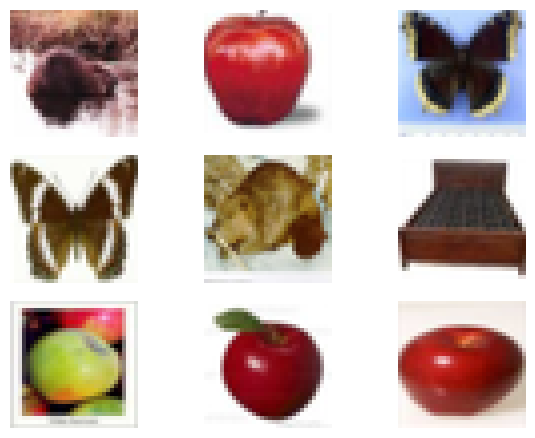

15


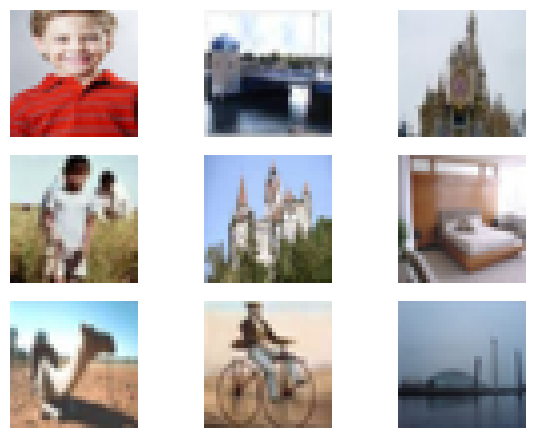

16


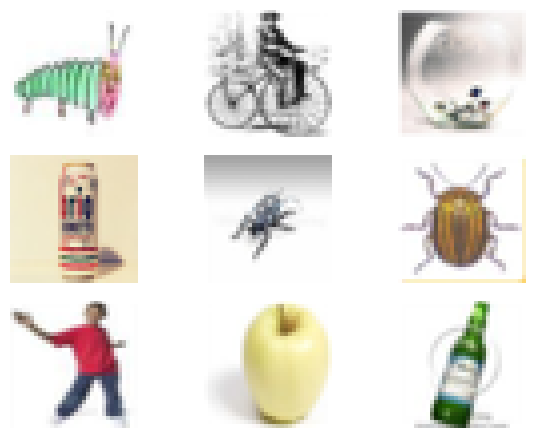

17


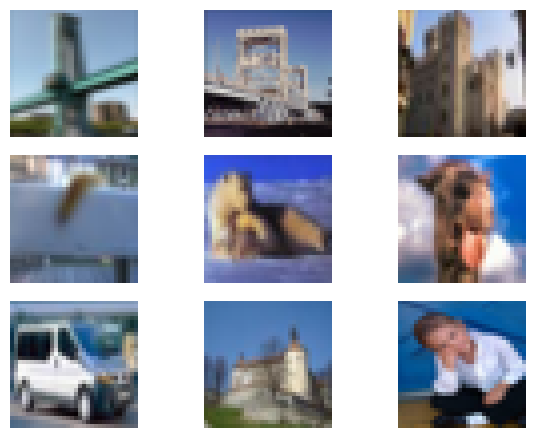

18


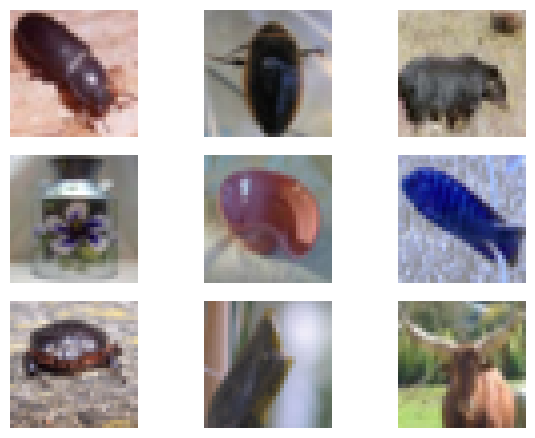

19


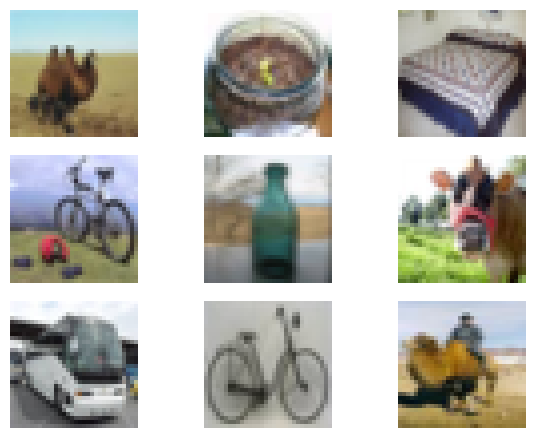

In [24]:
# PCA
kmeans = KMeans(n_clusters=20, random_state=0)
pca_model = PCA(n_components=20).fit(X_flat)
encoded = pca_model.transform(X_flat)
kmeans_pca = kmeans.fit(encoded)

# visualize_kmeans_centre(kmeans_model1, pca_model, n=n_clusters, ncol=n_clusters)

cluster_index_dict = clusters_to_index(kmeans_pca.labels_)
for cluster in sorted(list(cluster_index_dict.keys())):
    print(cluster)
    image_index = cluster_index_dict[cluster]
    images = X[image_index]
    visualize_data(images, n=9, ncol=3, plt_size=6)

0


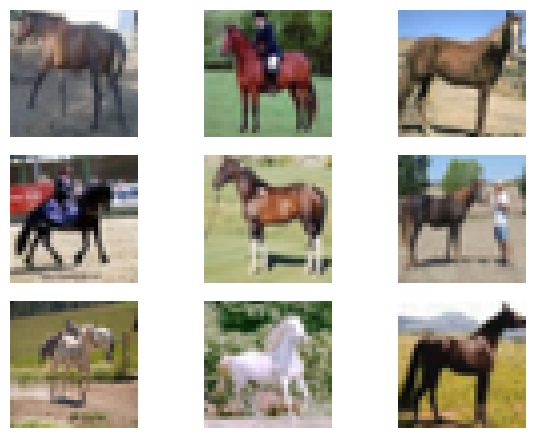

1


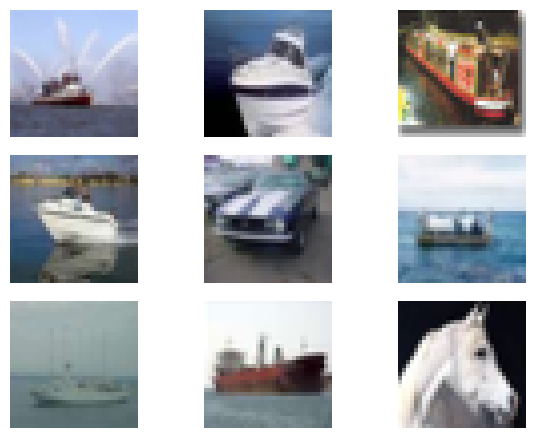

2


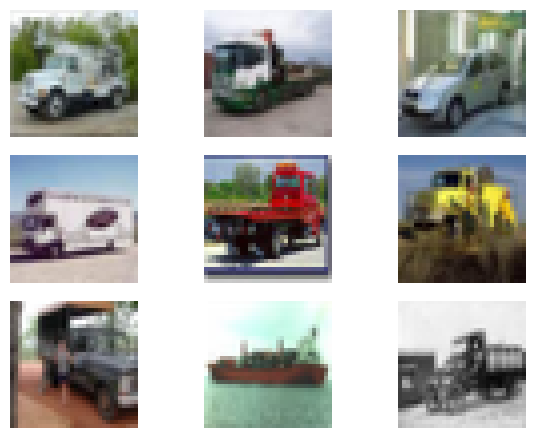

3


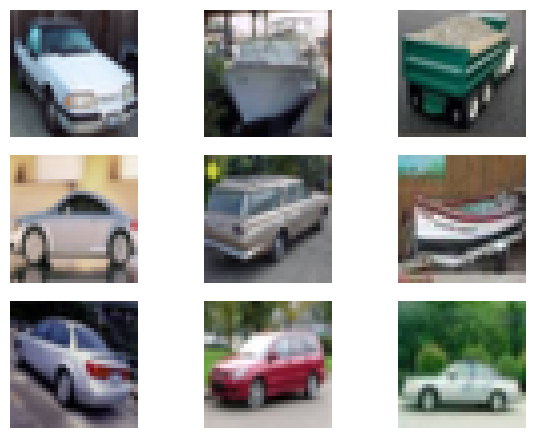

In [15]:
# siamese
kmeans = KMeans(n_clusters=4, random_state=0)
SNN = load_SNN(vec_size=20)
X_vec = get_SNN_vec(SNN, X)
kmeans_siamese = kmeans.fit(X_vec)

# visualize
cluster_index_dict = clusters_to_index(kmeans_siamese.labels_)
for cluster in sorted(list(cluster_index_dict.keys())):
    print(cluster)
    image_index = cluster_index_dict[cluster]
    images = X[image_index]
    visualize_data(images, n=9, ncol=3, plt_size=6)

(1000, 2)
11176.658063383722
7485.513516199147


c:\Users\junbo\anaconda3\envs\csc2515\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


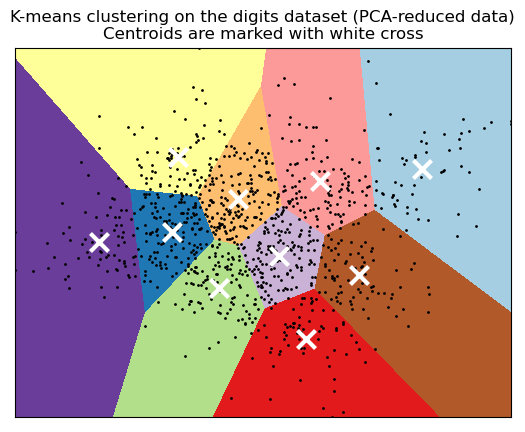

In [87]:
# visualizing clusters
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(test_vec)[0:1000]
print(reduced_data.shape)
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 2  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
print(x_max - x_min)
print(y_max - y_min)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on cifar10 dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [15]:
from sklearn import metrics
print(metrics.rand_score(labels, test_labels))
print(metrics.adjusted_rand_score(labels, test_labels))
print(metrics.adjusted_mutual_info_score(labels, test_labels))
print(metrics.normalized_mutual_info_score(labels, test_labels))
# metrics.homogeneity_score(labels_true, labels_pred)
# metrics.completeness_score(labels_true, labels_pred)
# metrics.v_measure_score(labels_true, labels_pred)
print(metrics.homogeneity_completeness_v_measure(labels, test_labels))
print(metrics.silhouette_score(encoded, labels, metric='euclidean'))
#print(metrics.adjusted_rand_score([0,0,1,1,2,2], [4,4,5,5,6,6]))

NameError: name 'labels' is not defined

In [54]:
x = np.array([122,3,52,3,3,21,12])
a = np.argwhere(x == 3).squeeze()
print(a)
print(np.random.permutation(a))

[1 3 4]
[3 4 1]


In [45]:
b = np.array([])
c = np.ones(2)
print(c.shape)
b = np.concatenate((b, c), axis=0)
b = np.concatenate((b, c), axis=0)
print(b.shape)

(2,)
(4,)
